In [2]:
import yfinance as yf
from pandas_datareader import data as pdr
import datetime as dt
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

In [3]:
yf.pdr_override()
df = pdr.get_data_yahoo("NQ=F", start="2022-03-20", end="2023-03-30")
#df = pd.DataFrame(data = df, columns=['Open','High', 'Low','Close','Adj Close','Volume'])
if isinstance(df, pd.DataFrame):
    df.head()

[*********************100%***********************]  1 of 1 completed


In [4]:
df.to_csv("Price_NQ.csv")

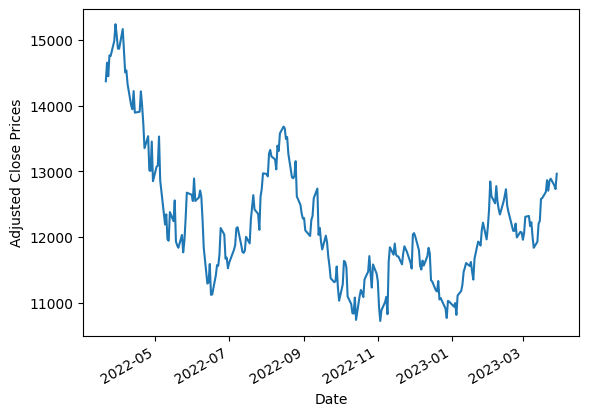

In [5]:
df['Adj Close'].plot()
plt.ylabel("Adjusted Close Prices")
plt.show()

In [6]:
df.dropna(inplace=True)

In [7]:
x = df.iloc[:, 0:5].values
y = df.iloc[:, 4].values
x.shape
y.shape

(260,)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.26,  random_state=0)

In [9]:
scale = StandardScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

In [10]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

grid_rf = {
'n_estimators': [20, 50, 100, 500, 1000],  
'max_depth': np.arange(1, 15, 1),  
'min_samples_split': [2, 10, 9], 
'min_samples_leaf': np.arange(1, 15, 2, dtype=int),  
'bootstrap': [True, False], 
'random_state': [1, 2, 30, 42]
}
rscv = RandomizedSearchCV(estimator=model, param_distributions=grid_rf, cv=3, n_jobs=-1, verbose=2, n_iter=200)
rscv_fit = rscv.fit(x_train, y_train)
best_parameters = rscv_fit.best_params_
print(best_parameters)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
{'random_state': 42, 'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': False}


In [11]:
model = RandomForestRegressor(n_estimators=1000, random_state=1, min_samples_split=2, min_samples_leaf=1, max_depth=11, bootstrap=True)
model.fit(x_train, y_train)
predict = model.predict(x_test)
print(predict)
print(predict.shape)

[12110.035      13306.82075    12091.56925    12147.3275
 11865.75475    11710.554      14937.47775    11532.88475
 11939.02       11709.62325    12057.7265     12618.34922266
 12627.54006055 13134.704      11281.57741895 11774.85925
 12207.399      11090.54819824 11634.83625    10835.304
 11475.634      15142.4215     11312.7295     12698.565
 10930.3825     11576.66975    12279.29925    12353.23025
 11788.15025    12070.4805     12624.26186133 12735.2855
 12037.95075    13268.26       10999.17675    12114.2835
 11809.85725    11565.805      11742.5255     11220.9372793
 14847.17775    13829.4915     11790.8455     12269.23975
 14598.50125    12010.856      10847.29225    12005.30875
 11334.24763965 11565.09275    11579.13325    12038.60875
 11933.972      11563.8635     11879.28225    10835.45975
 11330.87738965 12919.45025    11442.45175    12913.4335
 12973.14125    13974.092      11624.3265     14044.0655
 10870.11575    11176.13930664 11095.15380859 11752.98925   ]
(68,)


In [12]:
print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, predict), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, predict), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, predict)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, predict), 4))
print(f'Train Score : {model.score(x_train, y_train) * 100:.2f}% and Test Score : {model.score(x_test, y_test) * 100:.2f}% using Random Tree Regressor.')
errors = abs(predict - y_test)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.') 

Mean Absolute Error: 19.253
Mean Squared Error: 1321.026
Root Mean Squared Error: 36.3459
(R^2) Score: 0.9987
Train Score : 99.98% and Test Score : 99.87% using Random Tree Regressor.
Accuracy: 99.85 %.


In [13]:
predictions = pd.DataFrame({"Predictions": predict}, index=pd.date_range(start=df.index[-1], periods=len(predict), freq="D"))
predictions.to_csv("Predicted-price-data.csv")
#colllects future days from predicted values
oneyear_df = pd.DataFrame(predictions[:252])
oneyear_df.to_csv("one-year-predictions.csv")
onemonth_df = pd.DataFrame(predictions[:21])
onemonth_df.to_csv("one-month-predictions.csv")
fivedays_df = pd.DataFrame(predictions[:5])
fivedays_df.to_csv("five-days-predictions.csv")

Buy price and date
    Unnamed: 0  Predictions
19  2023-04-17    10835.304
19    10835.304
Name: Predictions, dtype: float64
Sell price and date
6    14937.47775
Name: Predictions, dtype: float64


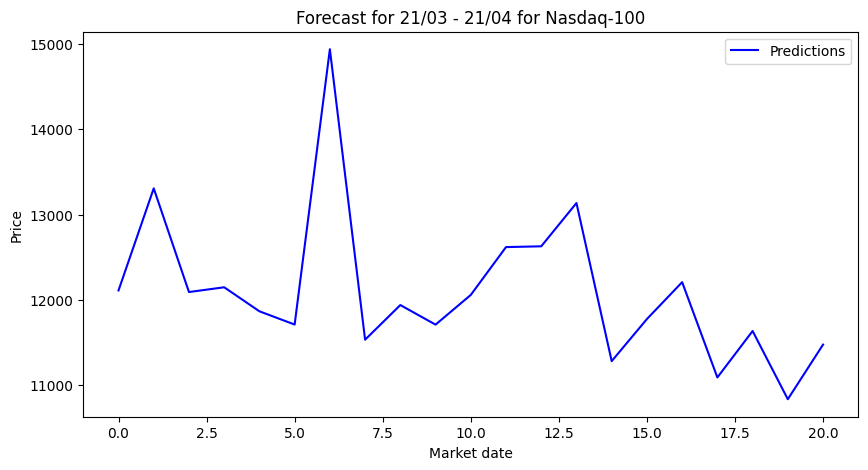

In [14]:
onemonth_df_pred = pd.read_csv("one-month-predictions.csv")
buy_price = min(onemonth_df_pred["Predictions"])
sell_price = max(onemonth_df_pred["Predictions"])
onemonth_buy = onemonth_df_pred.loc[onemonth_df_pred["Predictions"] == buy_price]
onemonth_sell = onemonth_df_pred.loc[onemonth_df_pred["Predictions"] == sell_price]
print("Buy price and date")
print(onemonth_buy)
print(onemonth_buy.loc[:, 'Predictions'])
print("Sell price and date")
print(onemonth_sell.loc[:, 'Predictions'])
onemonth_df_pred["Predictions"].plot(figsize=(10, 5), title="Forecast for 21/03 - 21/04 for Nasdaq-100", color="blue")
plt.xlabel("Market date")
plt.ylabel("Price")
plt.legend()
plt.show()